In [24]:
import sys
import os
import jax.numpy as jnp
import jax
import numpy as np
import matplotlib.pyplot as plt
from jax import grad, jit, vmap
import numpyro
from numpyro import distributions as dist
from numpyro import infer

from numpyro_ext import distributions as distx
from numpyro_ext import info, optim

from jax0planet.oblate import OblateSystem, OblateBody, OblateTransitOrbit
from jax0planet.light_curve import oblate_lightcurve
from jaxoplanet.light_curves import limb_dark_light_curve
from jaxoplanet.orbits import TransitOrbit
import jax
import jax.numpy as jnp
import arviz as az
import corner as crnr
import matplotlib.pyplot as plt

numpyro.set_host_device_count(2)  # For multi-core parallelism (useful when running multiple MCMC chains in parallel)
numpyro.set_platform("cpu")  # For CPU (use "gpu" for GPU)
jax.config.update("jax_enable_x64", True)
#jax.config.update('jax_disable_jit', True)
os.environ["XLA_FLAGS"] = "--xla_force_host_platform_device_count=2"

In [54]:
truths = {'period':300.456,
          'radius':0.1,
          'u':jnp.array([0.2,0.2, 0.2, 0.2]),
          'f':0.1,
          'θ':jnp.radians(30.),
          'bo':0.4,
          'duration':0.4
}

orbit = TransitOrbit(
    period=truths['period'], time_transit=0, duration=truths['duration'], impact_param=truths['bo'], radius=truths['radius']
)
oblate_orbit = OblateTransitOrbit(
    period=truths['period'], time_transit=0, duration=truths['duration'], impact_param=truths['bo'], radius=truths['radius'], f=truths['f'], theta=truths['θ']
)

t = jnp.linspace(-0.3, 0.3, 200)
lc = jax.vmap(limb_dark_light_curve(orbit, truths['u']))(t)

oblate_lc = oblate_lightcurve(orbit=oblate_orbit, u=truths['u'], t=t)

Text(0, 0.5, 'Residuals (ppm)')

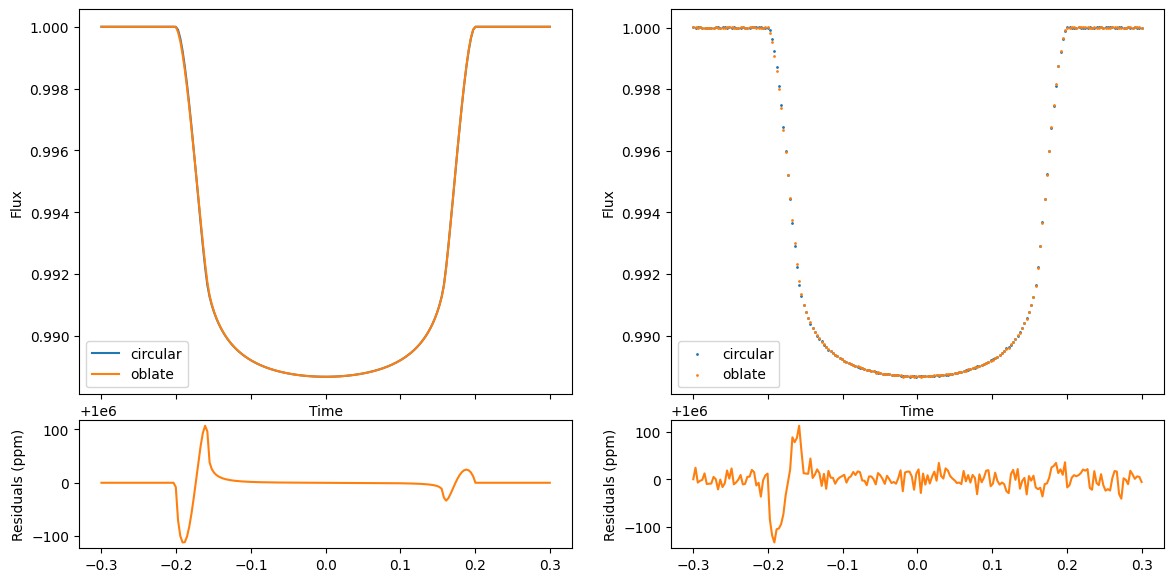

In [69]:
fig, ([ax, ax3],[ax1,ax4]) = plt.subplots(2,2,figsize=(14,7), gridspec_kw={'height_ratios': [3, 1]},sharex=True)
plt.subplots_adjust(hspace = 0.1)
ax.plot(t, lc+1, color="C0", label='circular')
ax.plot(t, oblate_lc, color="C1", label='oblate')
ax.legend();
ax.set_ylabel('Flux')
ax.set_xlabel('Time')
ax1.plot(t, (oblate_lc - lc)*1e6, color="C1")
ax1.set_ylabel('Residuals (ppm)')

random = np.random.default_rng(42)
t = jnp.linspace(-0.3, 0.3, 200)
yerr = 1e-5
sim_lc = jax.vmap(limb_dark_light_curve(orbit, truths['u']))(t)+yerr*random.normal(size=len(t))

sim_oblate_lc = oblate_lightcurve(orbit=oblate_orbit, u=truths['u'], t=t)+yerr*random.normal(size=len(t))
plt.subplots_adjust(hspace = 0.1)
ax3.scatter(t, sim_lc+1, color="C0", label='circular',s=1)
ax3.scatter(t, sim_oblate_lc, color="C1", label='oblate',s=1)
ax3.legend();
ax3.set_ylabel('Flux')
ax3.set_xlabel('Time')
ax4.plot(t, (sim_oblate_lc - sim_lc)*1e6, color="C1")
ax4.set_ylabel('Residuals (ppm)')

/Users/shishir/opt/anaconda3/envs/py39/lib/python3.9/site-packages/lightkurve/lightcurve.py:278: LightkurveDeprecationWarning: passing flux as a positional argument is deprecated, please use ``flux=...`` instead.
  warnings.warn(


(0.999, 1.001)

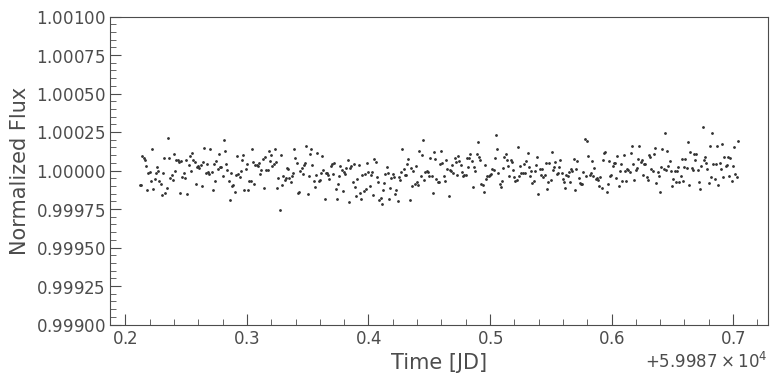

In [112]:
from astropy.io import ascii
import lightkurve as lk
path = '/Users/shishir/Documents/Astronomy/USQ/oblate_planet/MAST_2024-04-18T0707/JWST/jw02149-o002_t001_nirspec_f290lp-g395h-sub2048/jw02149-o002_t001_nirspec_f290lp-g395h-sub2048_whtlt.ecsv'
v1298_lc = ascii.read(path)
v1298_lc
sortmask = np.argsort(v1298_lc['MJD'])
t = v1298_lc['MJD'][sortmask]
flux = v1298_lc['whitelight_flux'][sortmask]
t
#plt.scatter(t,flux)
mask = np.where(flux>0)
t = t[mask]
flux = flux[mask]+5000

lklc = lk.LightCurve(t,flux)
lklc.normalize().bin(0.001).scatter()
plt.ylim(0.999,1.001)


In [70]:
def model(t, yerr, y=None):
    # If we wanted to fit for all the parameters, we could use the following,
    # but we'll keep these fixed for simplicity.
    
    #log_duration = numpyro.sample("log_duration", dist.Uniform(jnp.log(0.08), jnp.log(0.2)))
    #b = numpyro.sample("b", dist.Uniform(0.0, 1.0))

    #log_jitter = numpyro.sample("log_jitter", dist.Normal(jnp.log(yerr), 1.0))
    
    r = numpyro.sample("r", dist.Uniform(0.01, 0.2))
    u = numpyro.sample("u", distx.QuadLDParams())
    bo = numpyro.sample("bo", dist.Uniform(0.0,1.))
    
    #parametrize f, theta using a unit disk
    hk = numpyro.sample("hk", distx.UnitDisk())
    f = numpyro.deterministic("f", hk[0] ** 2 + hk[1] ** 2)
    theta = numpyro.deterministic("theta", jnp.arctan2(hk[1], hk[0])/2)
    
    # The duration
    log_d = numpyro.sample("log_d", numpyro.distributions.Normal(jnp.log(0.4), 0.1))
    duration = numpyro.deterministic("duration", jnp.exp(log_d))
    
    params = {
        'period':truths['period'],
        't0': 1.0,
        "radius": r,
        'bo':bo,
        'u': u,
        'f':f, 
        'theta':theta,
        'duration': duration
    }
    orbit_params = OblateTransitOrbit(period=params['period'], time_transit=params['t0'], duration=params['duration'], impact_param=params['bo'], radius=params['radius'], f=params['f'], theta=params['theta'])
    y_pred = oblate_lightcurve(orbit=orbit_params, u=params['u'], t=t)
    numpyro.deterministic("light_curve", y_pred)
    numpyro.sample("flux", dist.Normal(y_pred, jnp.sqrt(yerr**2)),obs=y)